In [3]:
import scipy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [1]:
# The dynamics is from pp. 17, Eq. (2.22), https://www.kth.se/polopoly_fs/1.588039.1550155544!/Thesis%20KTH%20-%20Francesco%20Sabatino.pdf
# The constants is from Different Linearization Control Techniques for a Quadrotor System

# quadrotor physical constants
g = 9.81
m = 1.
Ix = 8.1 * 1e-3
Iy = 8.1 * 1e-3
Iz = 14.2 * 1e-3

def lqr(A, B, Q, R):
    """Solve the continuous time lqr controller.
    dx/dt = A x + B u
    cost = integral x.T*Q*x + u.T*R*u
    """
    # http://www.mwm.im/lqr-controllers-with-python/
    # ref Bertsekas, p.151

    # first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))

    # compute the LQR gain
    K = np.matrix(scipy.linalg.inv(R) * (B.T * X))

    eigVals, eigVecs = scipy.linalg.eig(A - B * K)

    return np.asarray(K), np.asarray(X), np.asarray(eigVals)
    
def quad_dyanimcs(x, u):
    x1, x2, y1, y2, z1, z2, phi1, phi2, theta1, theta2, psi1, psi2 = x.reshape(-1).tolist()
    ft, tau_x, tau_y, tau_z = u.reshape(-1).tolist()
    dot_x = np.array([
     x2,
     ft/m*(np.sin(phi1)*np.sin(psi1)+np.cos(phi1)*np.cos(psi1)*np.sin(theta1)),
     y2,
     ft/m*(np.cos(phi1)*np.sin(psi1)*np.sin(theta1)-np.cos(psi1)*np.sin(phi1)),
     z2,
     -g+ft/m*np.cos(phi1)*np.cos(theta1),
     phi2,
     (Iy-Iz)/Ix*theta2*psi2+tau_x/Ix,
     theta2,
     (Iz-Ix)/Iy*phi2*psi2+tau_y/Iy,
     psi2,
     (Ix-Iy)/Iz*phi2*theta2+tau_z/Iz])
    return dot_x

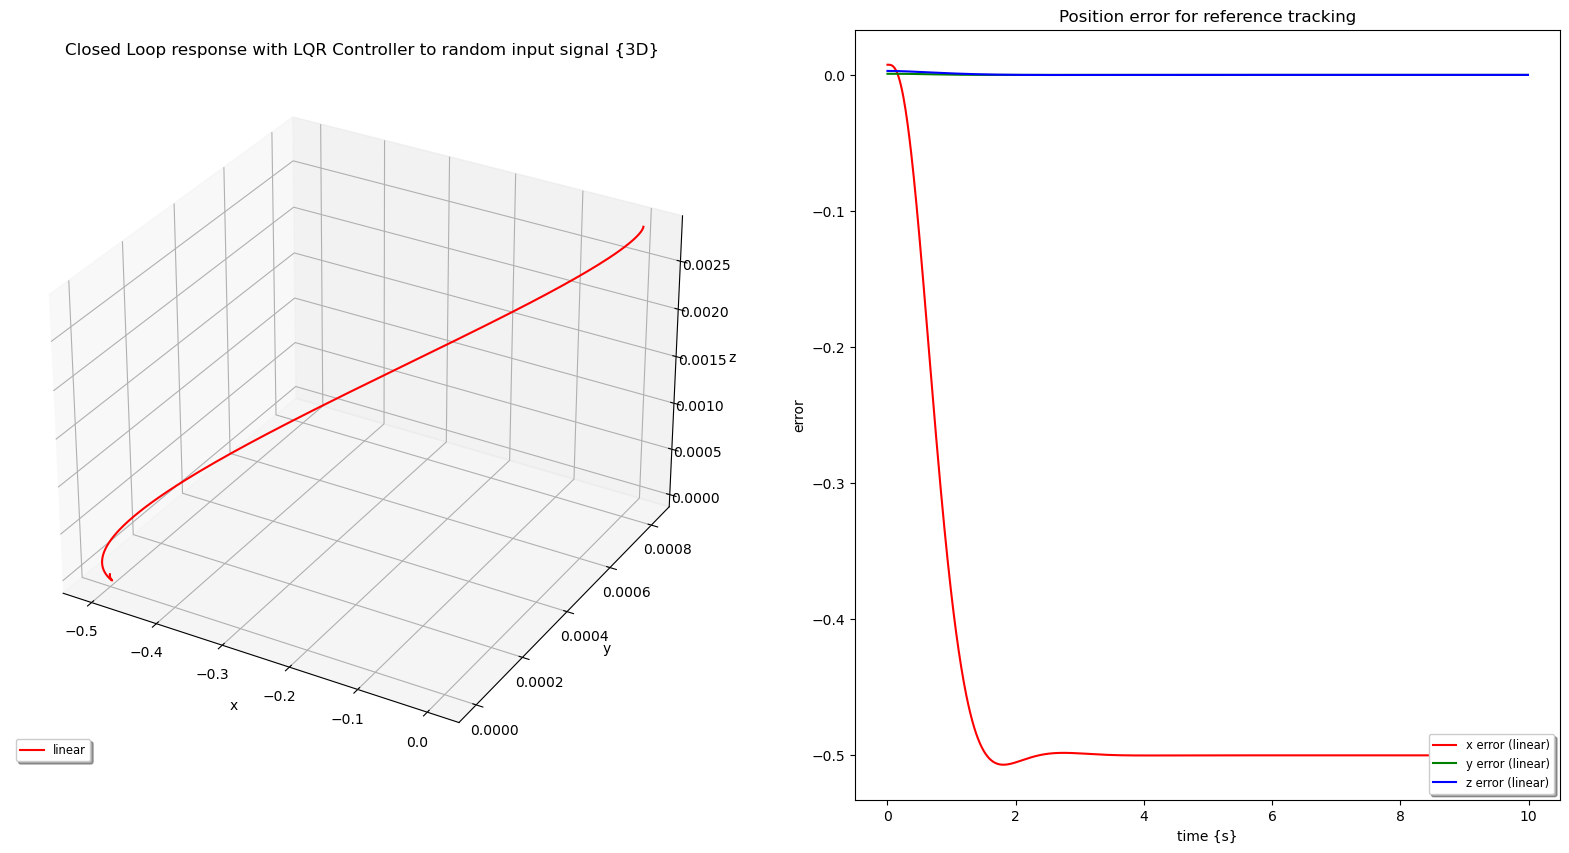

In [9]:
# 3D Control of Quadcopter
# based on https://github.com/juanmed/quadrotor_sim/blob/master/3D_Quadrotor/3D_control_with_body_drag.py
# The dynamics is from pp. 17, Eq. (2.22). https://www.kth.se/polopoly_fs/1.588039.1550155544!/Thesis%20KTH%20-%20Francesco%20Sabatino.pdf
# The linearization is from Different Linearization Control Techniques for
# a Quadrotor System (many typos)

# X-subsystem
# The state variables are x, dot_x, pitch, dot_pitch
Ax = np.array(
    [[0.0, 1.0, 0.0, 0.0],
     [0.0, 0.0, g, 0.0],
     [0.0, 0.0, 0.0, 1.0],
     [0.0, 0.0, 0.0, 0.0]])
Bx = np.array(
    [[0.0],
     [0.0],
     [0.0],
     [1 / Ix]])

# Y-subsystem
# The state variables are y, dot_y, roll, dot_roll
Ay = np.array(
    [[0.0, 1.0, 0.0, 0.0],
     [0.0, 0.0, -g, 0.0],
     [0.0, 0.0, 0.0, 1.0],
     [0.0, 0.0, 0.0, 0.0]])
By = np.array(
    [[0.0],
     [0.0],
     [0.0],
     [1 / Iy]])

# Z-subsystem
# The state variables are z, dot_z
Az = np.array(
    [[0.0, 1.0],
     [0.0, 0.0]])
Bz = np.array(
    [[0.0],
     [1 / m]])

# Yaw-subsystem
# The state variables are yaw, dot_yaw
Ayaw = np.array(
    [[0.0, 1.0],
     [0.0, 0.0]])
Byaw = np.array(
    [[0.0],
     [1 / Iz]])

####################### solve LQR #######################
Ks = []  # feedback gain matrices K for each subsystem
for A, B in ((Ax, Bx), (Ay, By), (Az, Bz), (Ayaw, Byaw)):
    n = A.shape[0]
    m = B.shape[1]
    Q = np.eye(n)
    Q[0, 0] = 10.  # The first state variable is the one we care about.
    R = np.diag([1., ])
    K, _, _ = lqr(A, B, Q, R)
    Ks.append(K)

######################## simulate #######################
# time instants for simulation
t_max = 10.0
t = np.arange(0., t_max, 0.01)


def cl_linear(x, t, u):
    # closed-loop dynamics. u should be a function
    x = np.array(x)
    X, Y, Z, Yaw = x[[0, 1, 8, 9]], x[[2, 3, 6, 7]], x[[4, 5]], x[[10, 11]]
    x[0]+=0.5
    UZ, UY, UX, UYaw = u(x, t).reshape(-1).tolist()
    dot_X = Ax.dot(X) + (Bx * UX).reshape(-1)
    dot_Y = Ay.dot(Y) + (By * UY).reshape(-1)
    dot_Z = Az.dot(Z) + (Bz * UZ).reshape(-1)
    dot_Yaw = Ayaw.dot(Yaw) + (Byaw * UYaw).reshape(-1)
    dot_x = np.concatenate(
        [dot_X[[0, 1]], dot_Y[[0, 1]], dot_Z, dot_Y[[2, 3]], dot_X[[2, 3]], dot_Yaw])
    return dot_x


# initial state
_X0 = 0.01 * np.random.randn(3)
X0 = np.zeros(12)
X0[[0, 2, 4]] = _X0

def u(x, _t):
    # the controller
    UX = Ks[0].dot(-x[[0, 1, 8, 9]])[0]
    UY = Ks[1].dot(-x[[2, 3, 6, 7]])[0]
    UZ = Ks[2].dot(-x[[4, 5]])[0]
    UYaw = Ks[3].dot(-x[[10, 11]])[0]
    return np.array([UZ, UY, UX, UYaw])


# simulate
x_l = odeint(cl_linear, X0, t, args=(u,))


######################## plot #######################
fig = plt.figure(figsize=(20, 10))
track = fig.add_subplot(1, 2, 1, projection="3d")
errors = fig.add_subplot(1, 2, 2)

track.plot(x_l[:, 0], x_l[:, 2], x_l[:, 4], color="r", label="linear")
track.set_title(
    "Closed Loop response with LQR Controller to random input signal {3D}")
track.set_xlabel('x')
track.set_ylabel('y')
track.set_zlabel('z')
track.legend(loc='lower left', shadow=True, fontsize='small')

errors.plot(t, x_l[:, 0], color="r", label='x error (linear)')
errors.plot(t, x_l[:, 2], color="g", label='y error (linear)')
errors.plot(t, x_l[:, 4], color="b", label='z error (linear)')

errors.set_title("Position error for reference tracking")
errors.set_xlabel("time {s}")
errors.set_ylabel("error")
errors.legend(loc='lower right', shadow=True, fontsize='small')

plt.show()